# Introduction to `kmod`

This notebook will introduce you to  `kmod`, a Python package implementing linear-time kernel-based model comparison tests as described in 

    Informative Features for Model Comparison
    Wittawat Jitkrittum, Heishiro Kanagawa, Patsorn Sangkloy, James Hays, Bernhard Schölkopf, Arthur Gretton
    NIPS 2018
    https://arxiv.org/abs/1810.11630

See the [Github page](https://github.com/wittawatj/kernel-mod) for installation instructions. This package depends on

* `kgof`: https://github.com/wittawatj/kernel-gof
* `freqopttest`: https://github.com/wittawatj/interpretable-test

Make sure that you have `kmod` included in Python's search path. In particular the following import statements should not produce any fatal error.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util, plot
from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Some plotting options. This block of code can be removed.
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 16
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

We use [`autograd`](https://github.com/HIPS/autograd) to compute derivatives for our optimization problem. So instead of 

    import numpy as np

make sure you use 

    import autograd.numpy as np

# Relative goodness-of-fit test

Given two candidate models $P$ and $Q$, and a sample $\{z_i \}_{i=1}^n \sim R$, where $R$ is an unknown data generating distribution, we address the problem of determining the relative goodness of fit of the two models. The problem is formulated as a test proposing

$H_0: D(P, R) \le D(Q,R)$

against 

$H_1: D(P, R) > D(Q,R),$

where $D$ is a distance between two distributions. In words, $H_0$ states that $P$ is closer to $R$ than $Q$ is i.e., $P$ fits $R$ better. The alternative $H_1$ states the opposite i.e., $Q$ fits $R$ better.

In this work, we propose two related tests: Rel-UME and Rel-FSSD:

* Rel-UME assumes that the two models $P$ and $Q$ are represented by two samples $\{x_i\}_{i=1}^n \stackrel{i.i.d.}{\sim} P$ and $\{y_i\}_{i=1}^n \stackrel{i.i.d.}{\sim} Q$, respectively.

* Rel-FSSD assumes that the unnormalized probability density functions $p,q$ of the two models $P$ and $Q$ are available. "Unnormalized" here means that the normalizer of each model is not needed by the test.


## Rel-UME

As a simple example, let us consider a two-dimensional example where $P,Q,R$ are mixtures of Gaussians. 

In [3]:
# p, q, r are mixtures of two Gaussians.
shared_component = [6, 0]
p_means = np.array([[-5, 0], shared_component])
p = density.IsoGaussianMixture(p_means, variances=[1, 0.4], pmix=[0.7, 0.3])

q_means=  np.array([[0, 1.3], shared_component])
q = density.IsoGaussianMixture(q_means, variances=[1, 0.4], pmix=[0.7, 0.3])

r_means = np.array([[0, 0], shared_component])
r = density.IsoGaussianMixture(r_means, variances=[1, 0.4], pmix=[0.7, 0.3])


In practice, the three samples `X, Y, Z` are given. Here, for illustration, we will generate them.

In [4]:
# P, Q, R must all be distinct. 
# Otherwise, it violates our assumption and the asymptotic null distribution does not hold.

# sample size
n = 400 
seed = 10

# Draw three samples
datap = p.get_datasource().sample(n, seed=seed)
dataq = q.get_datasource().sample(n, seed=seed+1)    
datar = r.get_datasource().sample(n, seed=seed+2)

In our code, a dataset is represented by an object of type `kmod.data.Data`. The input to the constructor of `kmod.data.Data` is a numpy array of size $n\times d$ where $n$ is the sample size, and $d$ is the dimension. Given a dataset `X`, `kmod.data.Data` can be constructed as

    datp = kmod.data.Data(X)

In [5]:
def plot_2d_data(X, Y, Z, V=None):
    """
    * X, Y, Z: n x d numpy arrays representing the data
    * V: J x d numpy arrays of J test locations
    """
    plt.figure(figsize=(8, 4))
    alpha = 0.5
    plt.plot(X[:, 0], X[:, 1], 'ro', alpha=alpha, label='P')
    plt.plot(Y[:, 0], Y[:, 1], 'bo', alpha=alpha, label='Q')
    plt.plot(Z[:, 0], Z[:, 1], 'ko', alpha=alpha, label='R')
    if V is not None:
        for (i, v) in enumerate(V):
            plt.plot(v[0], v[1], '^', color='m', markersize=20, label='V' if i==0 else '')
    plt.legend()
    
    plt.title('H1: Q is closer to R')
    

Plot the data

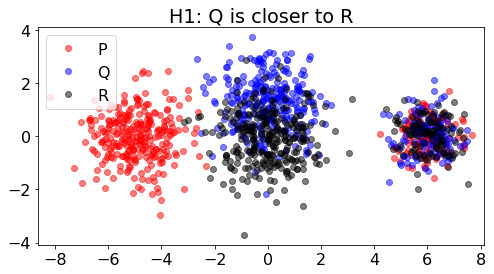

In [6]:
X = datap.data()
Y = dataq.data()
Z = datar.data()

# plot the data
plot_2d_data(X, Y, Z)
plt.axis('equal');

Here, the true distribution $R$ is a bimodal distribution (black). Both candidate models $P$ (red) and $Q$ (blue) are also bimodal distributions. Both models can capture well the right mode of $R$. However, $Q$ appears to capture the left mode of $R$ better (around the origin).

### Specify $J$ test locations for testing

Rel-UME measures relative goodness of fit of $P$ and $Q$ in the areas specified by a set of points. This set of points is known as the set of *test locations*, denoted by $V$. For simplicity, we will consider $J=1$ test location.

Define the hyperparameters of the test:

In [7]:
# Bandwidth of the Gaussian kernel. 
gw0 = 2**2

# Gaussian kernel
k0 = kernel.KGauss(gw0)

As an illustration, let us specify the test location (shown as purple in the following plot) at the right mode of $R$.

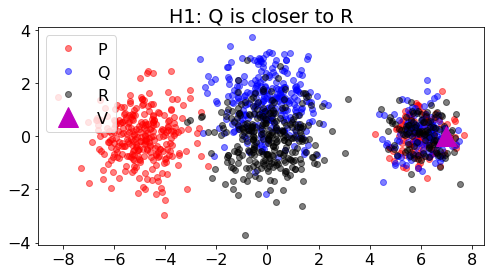

In [8]:
# Manually specify the test location(s)
# V0 in general is a J x d numpy array of J test locations in d dimensions.
V0 = np.array([[7, 0]])
plot_2d_data(X, Y, Z, V0)

Construct the Rel-UME test. This is implemented in `kmod.mctest.SC_GaussUME`.

In [9]:
# significance level of the test
alpha = 0.01  

# Construct an object to represent the test
scume0 = mct.SC_UME(datap, dataq, k0, k0, V0, V0, alpha=alpha)

# Do the test. Returns a dictionary
test_result = scume0.perform_test(datar)
display(test_result)

{'alpha': 0.01,
 'pvalue': 0.5411991137393245,
 'test_stat': -0.002345541194779246,
 'h0_rejected': False,
 'time_secs': 0.0010759830474853516}

We see that the test fails to reject H0. This means that there is not enough evidence to reject the null hypothesis that $P$ is better, *as measured at V*. Indeed, at the right mode of $R$, both models $P$ and $Q$ are equally good.

Now let us consider placing the test location around the origin where there is a clear difference between $P$ and $Q$.

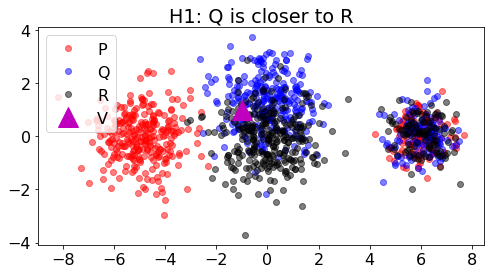

In [10]:
# new test location
V1 = np.array([[-1, 1]])
plot_2d_data(X, Y, Z, V1)

Do the test with this new test location.

In [11]:
scume1 = mct.SC_UME(datap, dataq, k0, k0, V1, V1, alpha=alpha)
scume1.perform_test(datar)

{'alpha': 0.01,
 'pvalue': 7.235461506193459e-20,
 'test_stat': 2.5475744306213324,
 'h0_rejected': True,
 'time_secs': 0.0006632804870605469}

The test rejects H0 with a small p-value in this case. This means that the test detects a significant difference in 
the (relative) goodness of fit of $P$ and $Q$, *as measured at V*. We have seen that the test result depends on the test location(s) V. This behaviour is a feature since it allows practitioners to pose a specific question: "Is Q better than P as measured around V?" In practice when $P$ and $Q$ are highly complicated, it is unlikely that one model is better than another uniformly over the input domain. That is, $P$ might better than $Q$ at $V_1$, and at the same time $Q$ might be better at $V_2$.

### Optimize the test locations and the Gaussian bandwidth

The test locations $V$ and the Gaussian bandwidth can also be tuned automatically by  maximizing the test power criterion of the Rel-UME test. The optimized test locations indicate the regions in the input domain where the better fit of $Q$ can be detected with highest probability.

Partition the data into training and test sets. We will use the training set for hyperparameter optimization,  and use the test set for testing.

In [12]:
# split the data into training/test sets

# proportion of the training data
tr_proportion = 0.2
[(datptr, datpte), (datqtr, datqte), (datrtr, datrte)] = \
    [D.split_tr_te(tr_proportion=tr_proportion, seed=85) for D in [datap, dataq, datar]]
Xtr, Ytr, Ztr = [D.data() for D in [datptr, datqtr, datrtr]]


In [13]:
def get_median_bandwidth(X, Y, Z):
    """
    A median heuristic to select the bandwidth of the Gaussian kernel.
    There are other variations.
    """
    medxz = util.meddistance(np.vstack((X, Z)), subsample=1000)
    medyz = util.meddistance(np.vstack((Y, Z)), subsample=1000)
    gwidth0 = np.mean([medxz, medyz])**2
    return gwidth0

In [14]:
# initialize optimization parameters.
# Initialize the Gaussian widths with the median heuristic
gwidth0 = get_median_bandwidth(Xtr, Ytr, Ztr)

# the number of test locations to optimize
J = 1

# pick a subset of points in the training set to initialize V
Xyztr = np.vstack((Xtr, Ytr, Ztr))
V0 = util.subsample_rows(Xyztr, J, seed=seed)

# optimization options
opt_options = {
    'max_iter': 100, # maximum number of gradient ascent iterations
    'reg': 1e-4, # regularization parameter in the optimization objective
    'tol_fun': 1e-7, # termination tolerance of the objective
    
    #Define a box bounds for the testing locations. 
    #extend the box defined by coordinate-wise min-max by std of each 
    #coordinate (of the aggregated data) multiplied by this number.
    'locs_bounds_frac': 50, 

    'gwidth_lb': 0.1, # absolute lower bound of the Gaussian width^2
    'gwidth_ub': 5**2, # abolute upper bound of the Gaussian width^2
}

# Optimize on the training set
V_opt, gw2_opt, opt_result = mct.SC_GaussUME.optimize_3sample_criterion(
    datptr, datqtr, datrtr, V0, gwidth0, **opt_options)    

The optimization procedure returns back 

1. `V_opt`: optimized test locations (features). A $J \times d$ numpy array.
2. `gw2_opt`: optimized squared Gaussian width (for the Gaussian kernel). A floating point number.
3. `opt_result`: a dictionary containing information gathered during the optimization.

In [15]:
print('Optimization details:')
display(opt_result)

Optimization details:


{'fun': -0.9836920653178426,
 'jac': array([ 3.43210917e-06, -5.10087471e-06,  2.90351197e-06]),
 'nfev': 10,
 'nit': 9,
 'status': 0,
 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'x': array([ 3.19641075,  1.50242378, -0.1454166 ]),
 'success': True,
 'hess_inv': <3x3 LbfgsInvHessProduct with dtype=float64>,
 'time_secs': 0.03727841377258301}

Let us use these optimized parameters to construct a Rel-UME test.  

In [16]:
# significance level of the test
alpha = 0.01  

# Gaussian kernel constructed with the optimized squared bandwidth
k_opt = kernel.KGauss(gw2_opt)

# Construct an object to represent the test. Use the test data here (not the training data!)
scume_opt3 = mct.SC_UME(datpte, datqte, k_opt, k_opt, V_opt, V_opt, alpha=alpha)

Perform model comparison test on the test data.

In [17]:
# returns a dictionary
test_result = scume_opt3.perform_test(datrte)
display(test_result)

{'alpha': 0.01,
 'pvalue': 1.1662610143420398e-63,
 'test_stat': 4.210327557737714,
 'h0_rejected': True,
 'time_secs': 0.0007669925689697266}

Plot the training data and the optimized test location(s).

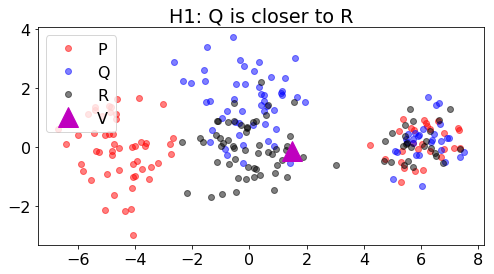

In [18]:
plot_2d_data(Xtr, Ytr, Ztr, V_opt)

----------------------

## Rel-FSSD

Rel-FSSD assumes that the unnormalized probability density functions $p,q$ of the two models $P$ and $Q$ are available. "Unnormalized" here means that the normalizer of each model is not needed by the test. The true data generating distribution $R$ is still represented as a sample $\{ z_i \}_{i=1}^n \sim R$.

As a simple example, let us consider the same toy example as in Figure 1c of our NIPS 2018 paper.

In [19]:
# models. p and q are Gaussian.
p = density.IsotropicNormal(mean=np.array([0]), variance=1)
q = density.IsotropicNormal(mean=np.array([6]), variance=1)

In general, you can implement your own density functions easily. See https://github.com/wittawatj/kernel-gof/blob/master/ipynb/demo_kgof.ipynb . Note that the modules `kgof.density` and `kmod.density` are interchangeable.

In [20]:
# r is a mixture of two Gaussians
r = density.IsoGaussianMixture(
    means=np.array([[0, 6]]).T,
    variances=np.array([1, 1]),
    pmix=[0.5, 0.5]
)
dsr = r.get_datasource()

# datr is of type `kmod.data.Data`. 
# As stated earlier, this can be constructed from a numpy array as well.
datr = dsr.sample(n=500, seed=59)

# datr.data() gives the underlying numpy array
Z = datr.data()

# median heuristic
med = util.meddistance(Z, subsample=1000)
k = kernel.KGauss(sigma2=med**2)

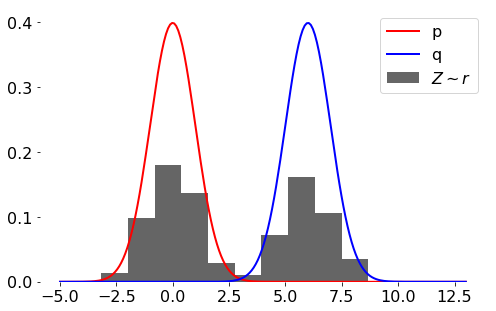

In [21]:
def plot_densities(p, q, Z, V=None):
    # plot the densities
    dom = np.linspace(-5, 13, 200)[:, np.newaxis]
    denp = np.exp(p.log_normalized_den(dom))
    denq = np.exp(q.log_normalized_den(dom))
#     denr = np.exp(r.log_normalized_den(dom))

    plt.figure(figsize=(8, 5))
    plt.box(False)
    density_lw = 2
    plt.plot(dom, denp, 'r-', linewidth=density_lw, label='p')
    plt.plot(dom, denq, 'b-', linewidth=density_lw, label='q')
#     plt.plot(dom, denr, 'k-', linewidth=density_lw, label='r')
    plt.hist(Z, density=True, color='k', alpha=0.6, label='$Z \sim r$')
    if V is not None:
        # test locations
        for (i, v) in enumerate(V):
            plt.plot(v[0], 0, '^m', markersize=26, label='V' if i==0 else '')
    plt.legend()
    
plot_densities(p, q, Z)

### Optimize the test locations and the Gaussian bandwidth


As in Rel-UME, the test locations $V$ and the Gaussian bandwidth can be tuned automatically by  maximizing the test power criterion of the Rel-FSSD test. The optimized test locations indicate the regions in the input domain where the better fit of $q$ can be detected with highest probability.

In [22]:
# Unlike Rel-UME, here we have only one sample from r since p, q 
# are density functions. No samples from p, q needed.
# Split the data from r into training/test sets.
datr_tr, datr_te = datr.split_tr_te(tr_proportion=0.2)

In [23]:
# initialize parameters to optimize
# Median heuristic computed on the training set
med = util.meddistance(datr_tr.data(), subsample=1000)
gwidth0 = med**2

# J = number of test locations
J = 1
Z_tr = datr_tr.data()
V0 = util.subsample_rows(Z_tr, J, seed=seed+2)

## Optimize
opt_options = {
    'max_iter': 100, # maximum number of gradient ascent iterations
    'reg': 1e-3, # regularization parameter in the optimization objective
    'tol_fun': 1e-7, # termination tolerance of the objective
    
    #Define a box bounds for the testing locations. 
    #extend the box defined by coordinate-wise min-max by std of each 
    #coordinate (of the aggregated data) multiplied by this number.
    'locs_bounds_frac': 50, 

    'gwidth_lb': 0.1, # absolute lower bound of the Gaussian width^2
    'gwidth_ub': 5**2, # abolute upper bound of the Gaussian width^2
}
V_opt, gw_opt, opt_info = mct.DC_GaussFSSD.optimize_power_criterion(p, q, datr_tr, V0, gwidth0, **opt_options)

/is/ei/wittawat/anaconda3/envs/kmod_pt0.4.1/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


In [24]:
print('Optimization details:')
opt_info

Optimization details:


{'fun': -0.5305458032749322,
 'jac': array([ 9.28203934e-08, -2.06127885e-08]),
 'nfev': 9,
 'nit': 8,
 'status': 0,
 'message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'x': array([2.14672622, 5.46846529]),
 'success': True,
 'hess_inv': <2x2 LbfgsInvHessProduct with dtype=float64>,
 'time_secs': 0.05961894989013672}

Use the optimized parameters to perform Rel-FSSD test.

In [25]:
# significance level
alpha = 0.01

# An object representing a Rel-FSSD test.
dcfssd_opt = mct.DC_GaussFSSD(p, q, gw_opt, gw_opt, V_opt, V_opt, alpha=alpha)

# perform test on the test data (not the training data!)
dcfssd_opt.perform_test(datr_te)

{'alpha': 0.01,
 'pvalue': 3.5594108523938086e-17,
 'test_stat': 103.10807796033978,
 'h0_rejected': True,
 'time_secs': 0.0019083023071289062}

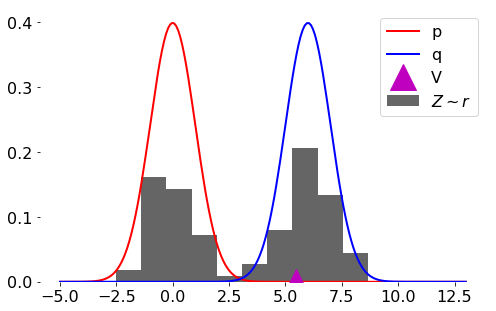

In [26]:
# training data
Ztr = datr_tr.data()
plot_densities(p, q, Ztr, V_opt)

The test rejects H0. The optimized test location indicates that $q$ fits better at the right mode of $r$.

### Better fit of p

One can also formulate the opposite hypothesis so that the alternative hypothesis states that "H1: p is better". 
To optimize for test locations which indicate the better fit of $p$, one simply switches arguments $p, q$ when calling the optimization function.


In [27]:
# Notice the first two arguments!
V_opt2, gw_opt2, _ = mct.DC_GaussFSSD.optimize_power_criterion(q, p, datr_tr, V0, gwidth0, **opt_options)

# Notice the first two arguments.
dcfssd_opt2 = mct.DC_GaussFSSD(q, p, gw_opt2, gw_opt, V_opt2, V_opt2, alpha=alpha)

# perform test on the test data (not the training data!)
dcfssd_opt2.perform_test(datr_te)

{'alpha': 0.01,
 'pvalue': 9.240358638515146e-28,
 'test_stat': 156.05068064972667,
 'h0_rejected': True,
 'time_secs': 0.0014743804931640625}

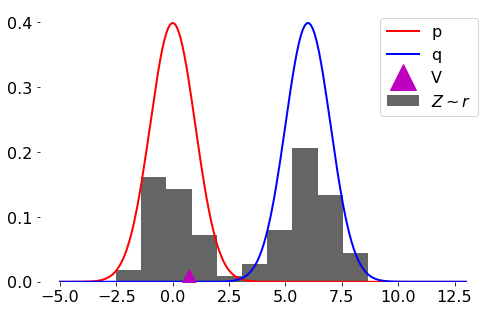

In [28]:
plot_densities(p, q, Ztr, V_opt2)

The test rejects the (reformulated) null hypothesis that $Q$ is better. The optimized location in this case indicates where $p$ fits better. 

We note that the behaviours of the test locations in Rel-UME and Rel-FSSD are slightly different. See the explanation of Figure 1 in our NIPS 2018 paper.